*Author: Daniel Puente Viejo*  

<img src="https://cdn-icons-png.flaticon.com/512/2318/2318736.png" width="100" height="100" float ="right">   


Once the data is clean and ready for analysis, the aim of this notebook is first to split the training and test sets to simulate a real environment.     
Subsequently we will continue with the analysis of the variables and generation of the final dataset for the subsequent creation of the graph `model_something`. For this purpose, the following index will be used:    
- <a href='#1'><ins>1. Loading of Libraries and Data<ins></a>
- <a href='#2'><ins>2. Feature engineering<ins></a>
- <a href='#3'><ins>3. Save data<ins> </a>

### <a id='1'>1. Loading of Libraries and Data</a>
----

* Common libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from itertools import chain
from scipy import stats

* Sklearn

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, roc_auc_score

* Paths and warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

path = "../data/cleaning_generated_data/"
output_path = "../data/eda_generated_data/"

* Load data

In [4]:
df = pd.read_csv(path + "application_data_fraud.csv")
info_df = pd.read_csv(path + "columns_description_fraud.csv", encoding='cp1252', index_col=0)
previous_df = pd.read_csv(path + "previous_application_fraud.csv")

### <a id=''>2. Feature Engineering</a>

---

Columns that may bias the model are eliminated.

In [5]:
df.drop(columns=['CODE_GENDER'], inplace=True)

We make a quick view to the unique values of each categorical feature and the amount of values that are by each category.   
We also make a quick view to the distribution of the numerical features.
* It all seems to be right. There are some categories that are not very abundant

In [6]:
df_num = df.select_dtypes(include=['float64', 'int64'])

categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(df[col].value_counts())
    print("**************************\n")

Cash loans         222308
Revolving loans     21972
Name: NAME_CONTRACT_TYPE, dtype: int64
**************************

N    158789
Y     85491
Name: FLAG_OWN_CAR, dtype: int64
**************************

Y    168943
N     75337
Name: FLAG_OWN_REALTY, dtype: int64
**************************

Unaccompanied      199218
Family              31633
Spouse, partner      8735
Children             2536
Other_B              1316
Other_A               636
Group of people       206
Name: NAME_TYPE_SUITE, dtype: int64
**************************

Working                 125885
Commercial associate     56151
Pensioner                43914
State servant            18311
Student                     13
Businessman                  4
Unemployed                   2
Name: NAME_INCOME_TYPE, dtype: int64
**************************

Secondary / secondary special    172102
Higher education                  61387
Incomplete higher                  7820
Lower secondary                    2835
Academic degree     

We make a quick view to the statistical values of each numerical feature.
* We see that *FLAG_MOBIL* and *FLAG_DOCUMENT_2* have only one value. We can eliminate them.

In [7]:
df_num.describe()
df_num.drop(columns=['FLAG_MOBIL', "FLAG_DOCUMENT_2"], inplace=True)
df.drop(columns=['FLAG_MOBIL', "FLAG_DOCUMENT_2"], inplace=True)

Taking a look to the unique values of the categorical data

In [8]:
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(df[col].value_counts())
    print("**************************\n")

Cash loans         222308
Revolving loans     21972
Name: NAME_CONTRACT_TYPE, dtype: int64
**************************

N    158789
Y     85491
Name: FLAG_OWN_CAR, dtype: int64
**************************

Y    168943
N     75337
Name: FLAG_OWN_REALTY, dtype: int64
**************************

Unaccompanied      199218
Family              31633
Spouse, partner      8735
Children             2536
Other_B              1316
Other_A               636
Group of people       206
Name: NAME_TYPE_SUITE, dtype: int64
**************************

Working                 125885
Commercial associate     56151
Pensioner                43914
State servant            18311
Student                     13
Businessman                  4
Unemployed                   2
Name: NAME_INCOME_TYPE, dtype: int64
**************************

Secondary / secondary special    172102
Higher education                  61387
Incomplete higher                  7820
Lower secondary                    2835
Academic degree     

We get the nunique values by each numeric categorical_columns
* Given that some of them are one hot encoded, we do not take those into account

In [9]:
nunique = df_num.nunique()
range_values = nunique[(nunique > 3) & nunique.index.isin(list(set(nunique.index) - set(['SK_ID_CURR','TARGET'])))]

#### Outliers detection
---- 

Outliers detection functions are developed

In [10]:
def __outliers_iqr(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    return list(df[(df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr)].index)

def __outliers_zscore(df, col):
    z = np.abs(stats.zscore(df[col]))
    return list(df[(z > 3) | (z < -3)].index) 

Divide the data in fraud and no fraud to apply the outliers detection and individual statistics 

In [11]:
df_num_no_target = df_num[df_num['TARGET'] != 1].loc[:, range_values.index]
df_num_target = df_num[df_num['TARGET'] == 1].loc[:, range_values.index]

🛑🛑   **¿¿¿ DAYS EMPLOYED ???** 🛑🛑

In [12]:
print(df_num_no_target[df_num_no_target.DAYS_EMPLOYED == 365243].shape, df_num_no_target[df_num_no_target.DAYS_EMPLOYED > 0].shape)
print(df_num_target[df_num_target.DAYS_EMPLOYED == 365243].shape, df_num_target[df_num_target.DAYS_EMPLOYED > 0].shape)

(41639, 25) (41639, 25)
(2270, 25) (2270, 25)


A new dataframe is created with numerical non dummiffied columns, except target.   
* The tarjet values are change to have a better understanding in the visualizations 

In [13]:
df_num_target_labeled = pd.concat([df_num.loc[:, range_values.index], df_num.TARGET], axis=1)
df_num_target_labeled.TARGET = df_num_target_labeled.TARGET.replace({0: 'No', 1: 'Yes'})

Some columns are removed because they are not relevant for the analysis

In [14]:
colss = np.array(df_num_no_target.columns)
colss = list(colss[~np.isin(colss, ['DAYS_EMPLOYED', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'EXT_SOURCE_2', 'EXT_SOURCE_3'])])

Plotting function is defined

In [15]:
def boxplot_by_targe(df, colss, title):

    for k, i in enumerate(colss):    
        
        iq = df.iloc[__outliers_iqr(df, i)].TARGET.value_counts()
        z = df.iloc[__outliers_zscore(df, i)].TARGET.value_counts()

        fig = plt.figure(figsize=(30, 3))
        sns.boxplot(data = df, x=i, y='TARGET', notch=True, flierprops={"marker": "x"}, boxprops={"facecolor": (38/255, 70/255, 83/255, .8)}, medianprops={"color": "coral"})

        if title: plt.title(f'{i} - No: {iq.No}, Yes: {iq.Yes} | No: {z.No}, Yes: {z.Yes}', fontdict={'size': 20, 'color': 'black', 'weight': 'bold'})
        plt.grid(linestyle='--',linewidth=1.5), plt.xticks(fontsize=16), plt.yticks(fontsize=16);

Looking at the boxplots, it is seen that some features have outliers and other are just integers

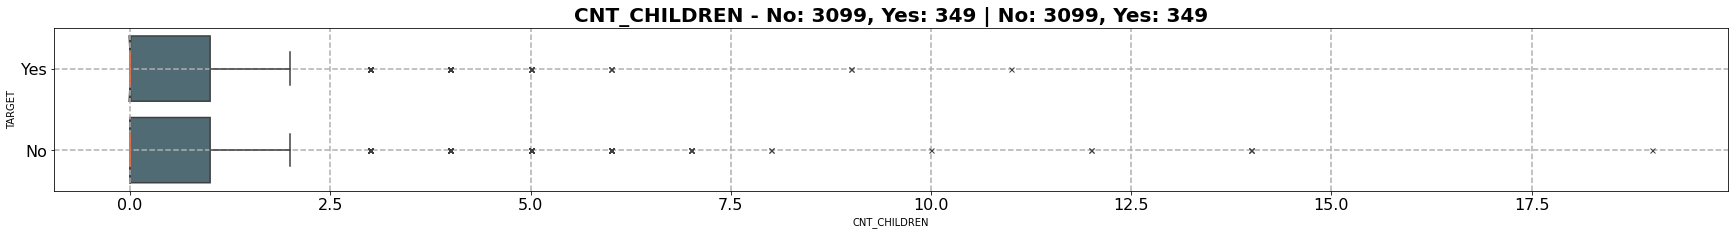

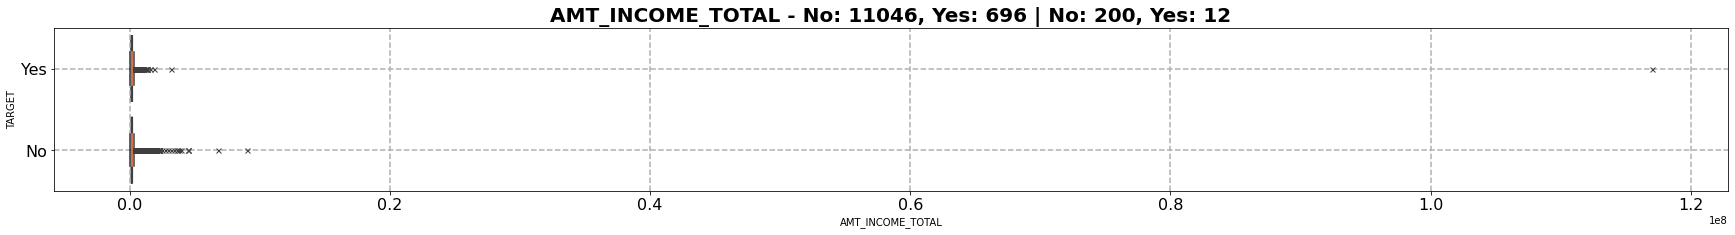

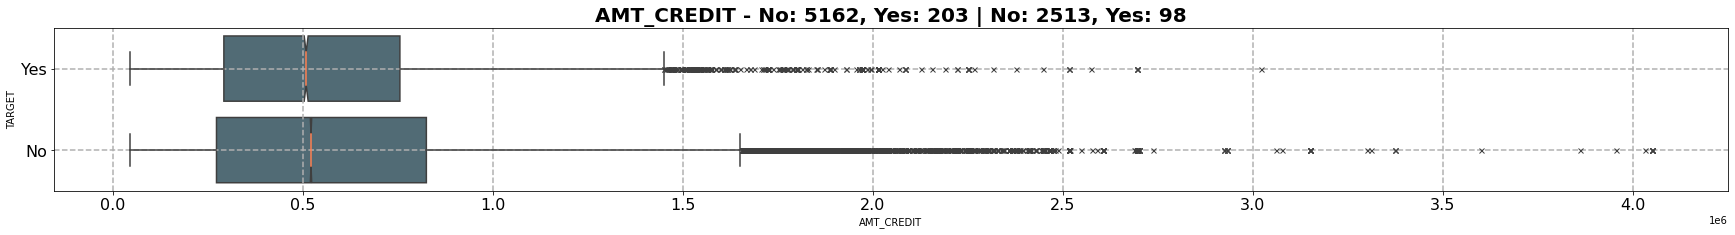

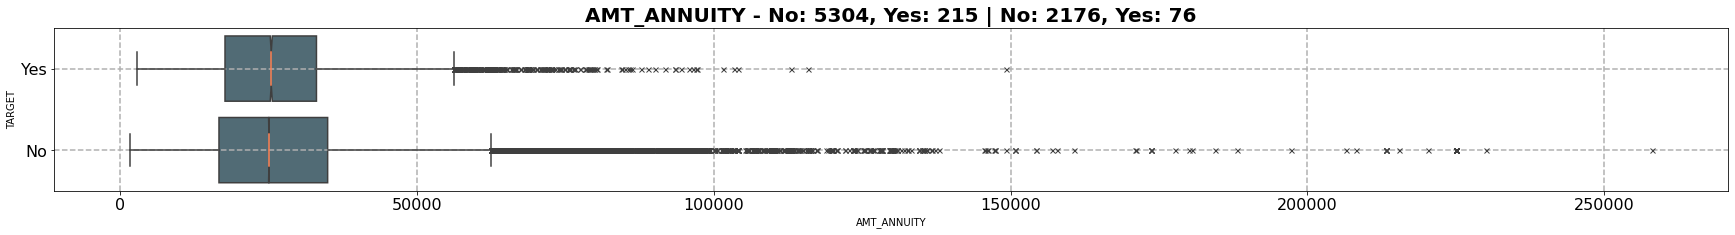

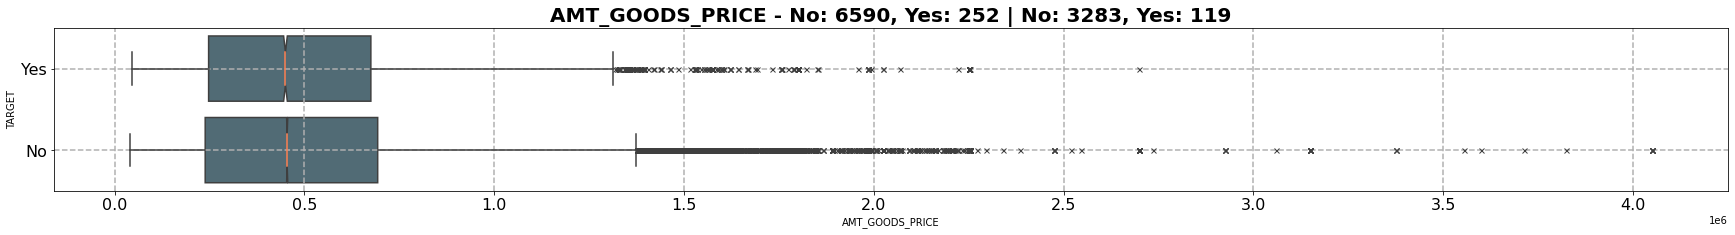

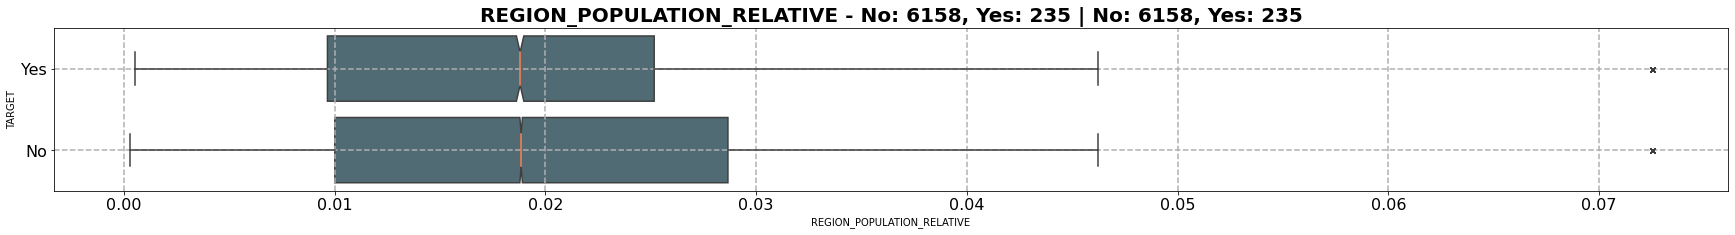

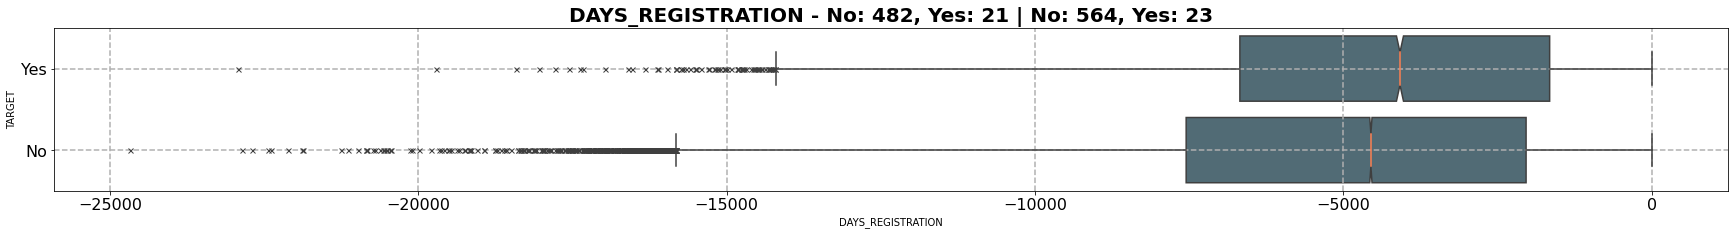

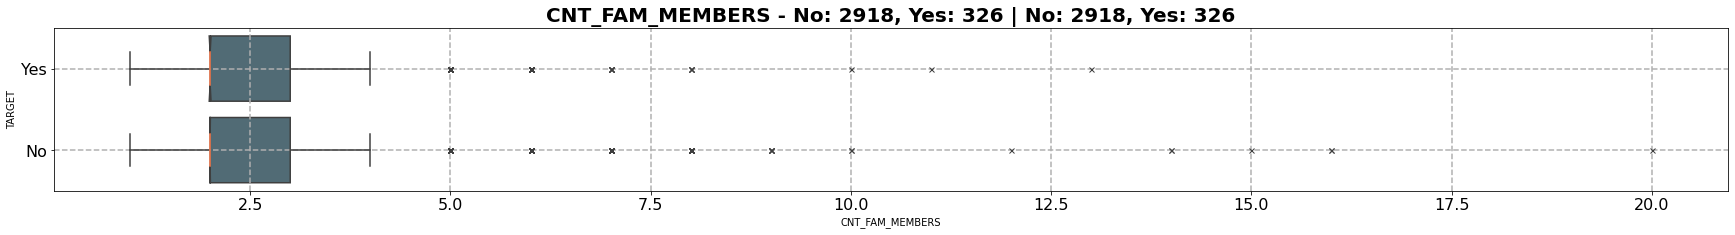

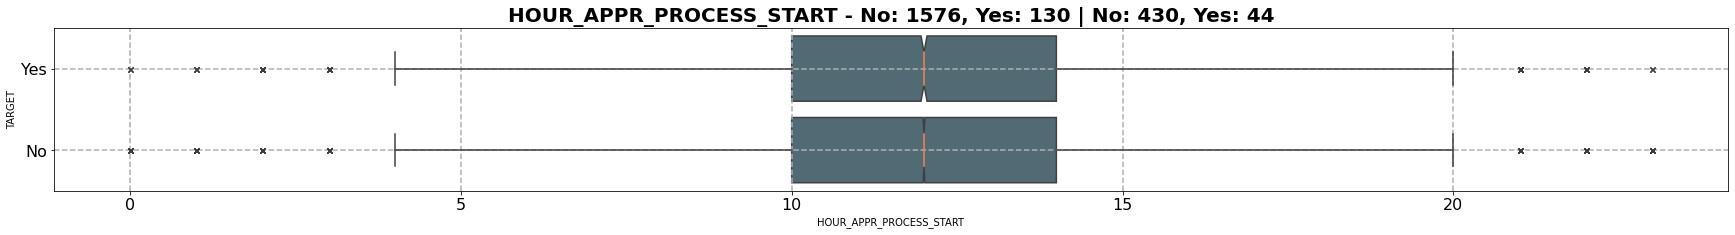

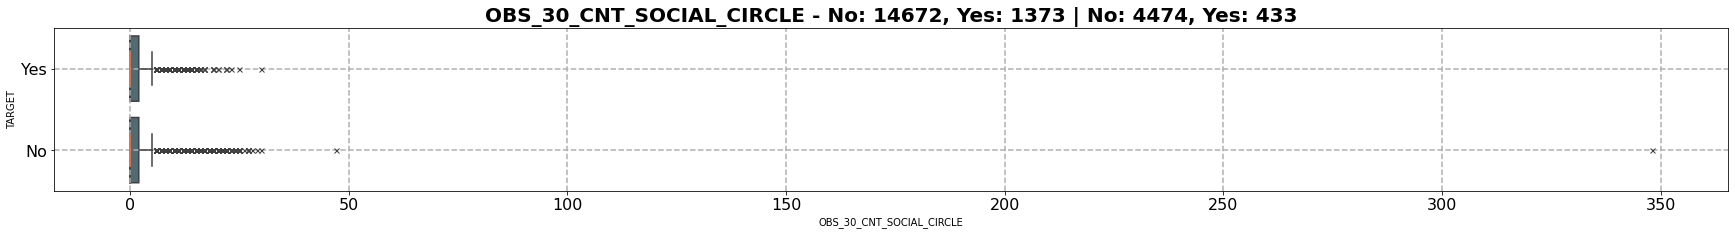

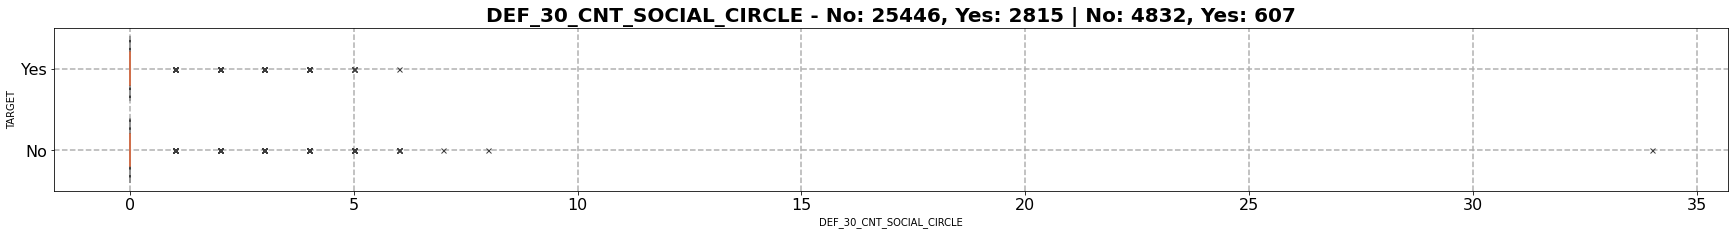

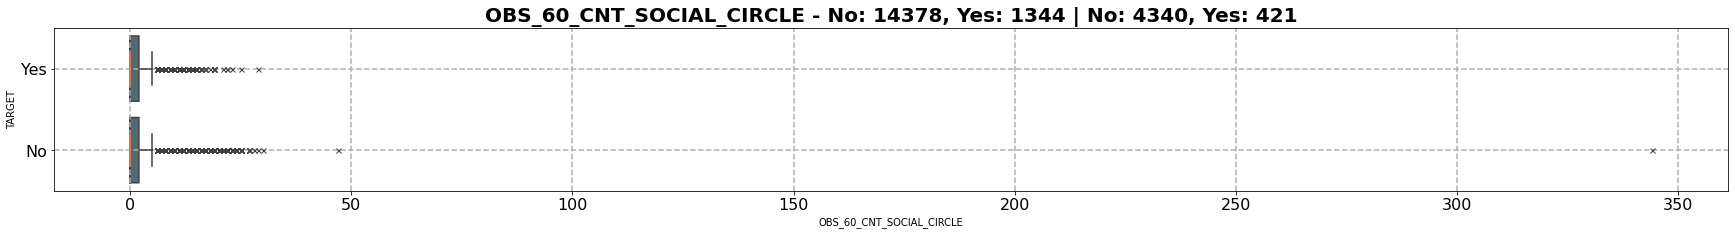

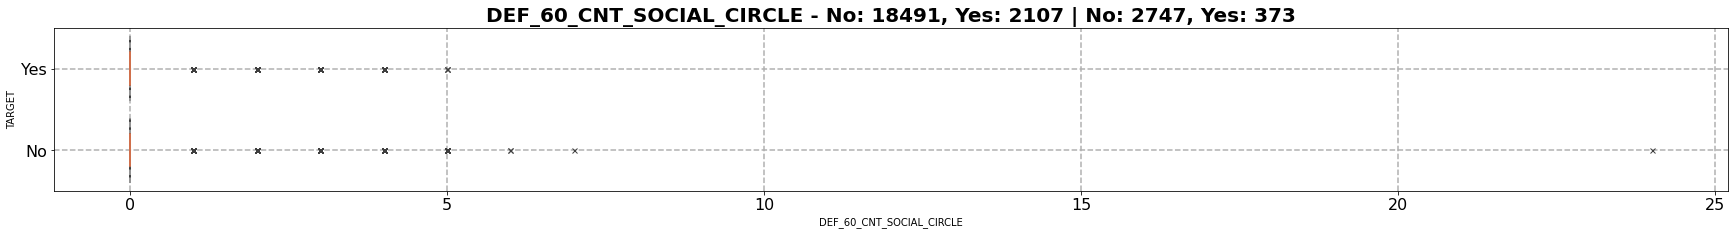

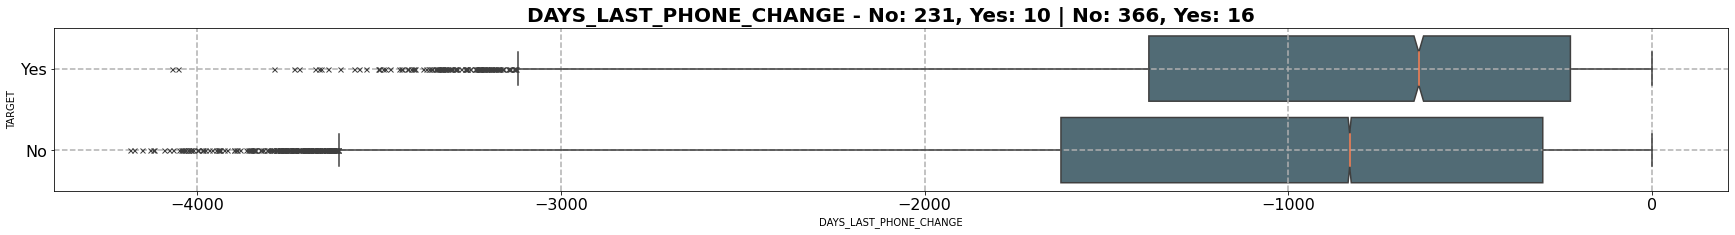

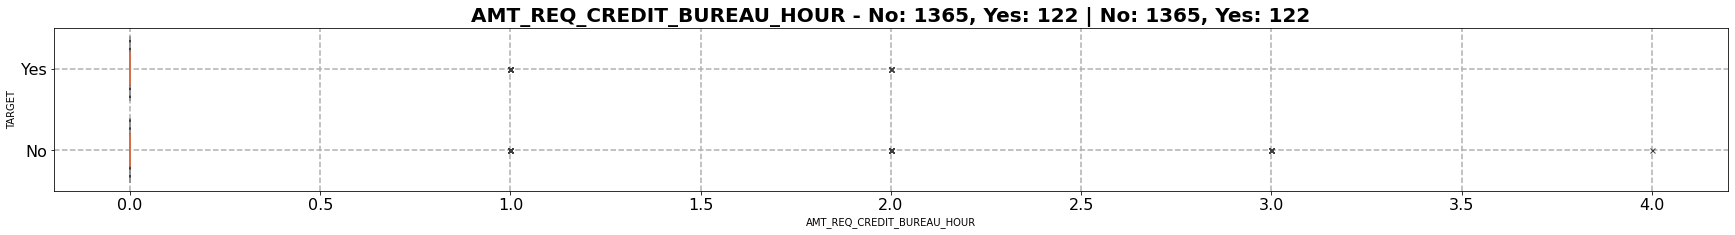

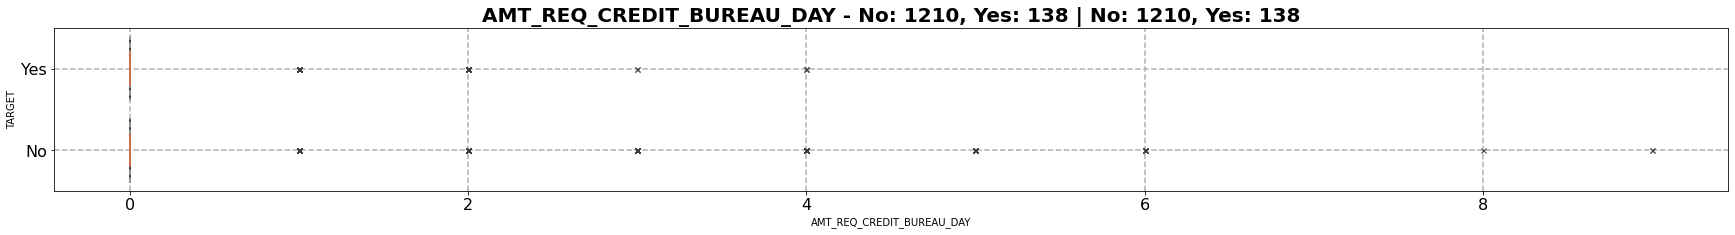

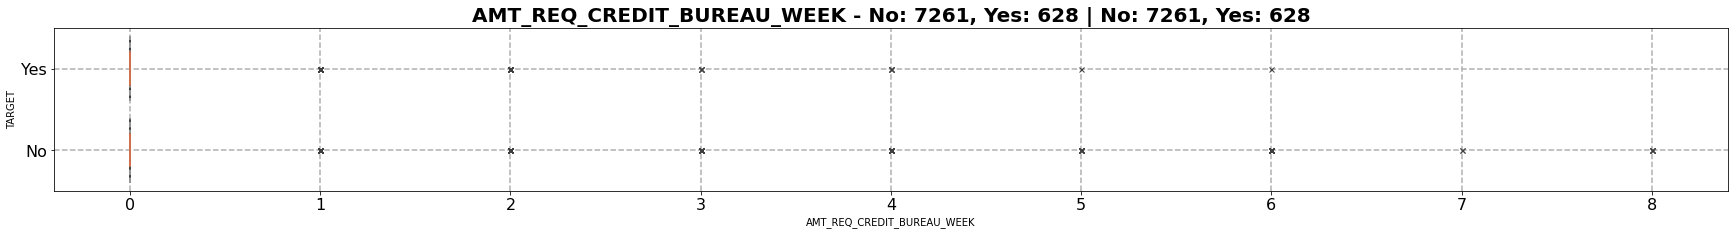

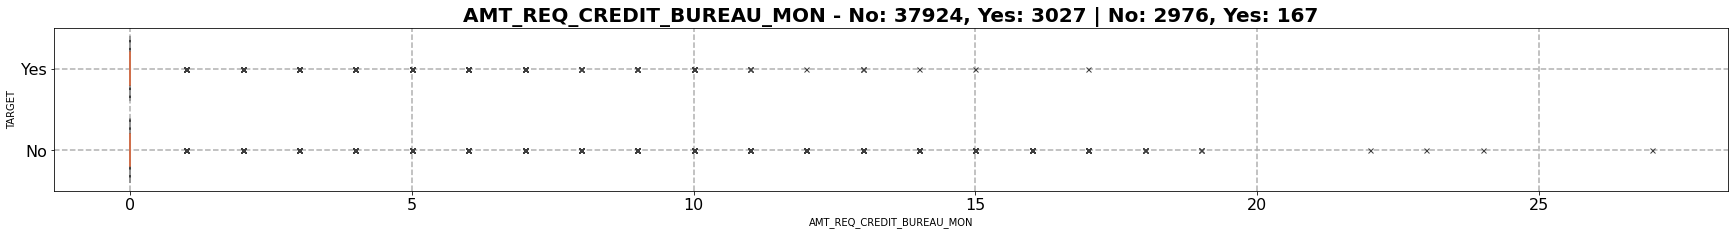

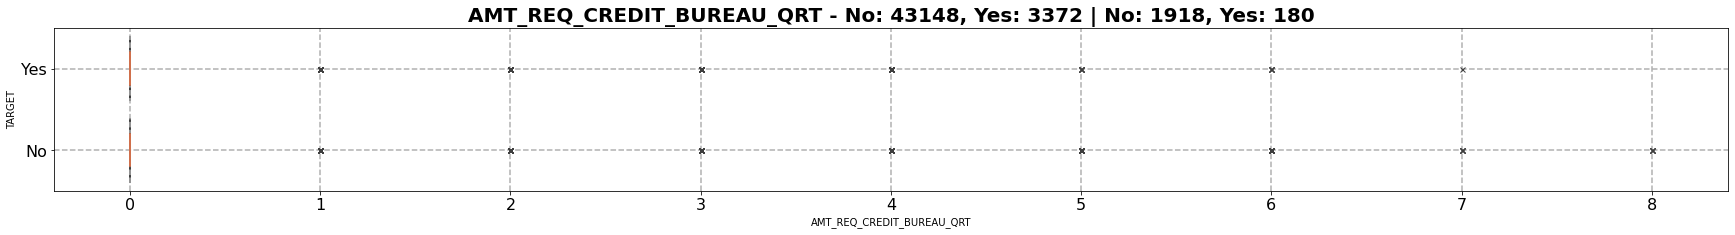

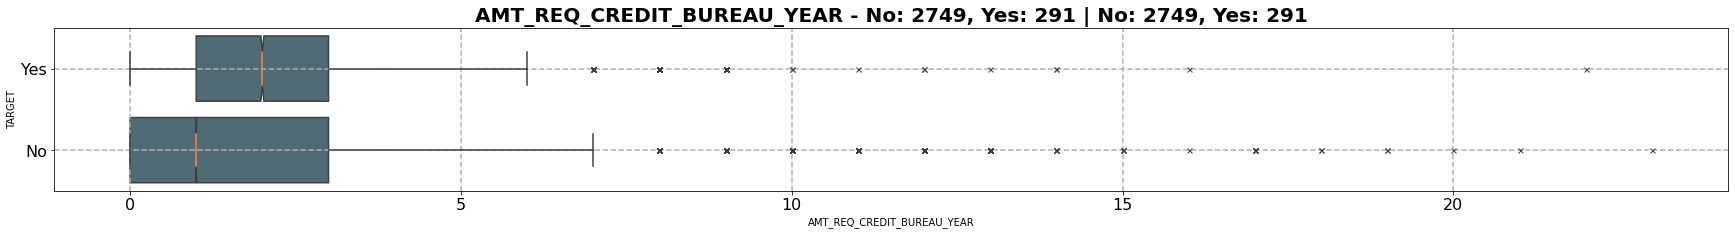

In [16]:
boxplot_by_targe(df_num_target_labeled, colss, True)

In [17]:
cols_selected = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE']

In multiple tests, removing outliers by category using the IQR method gives the best results.   
**IQR** 🥇

In [18]:
remove_instances = [__outliers_iqr(df_num_target_labeled[df_num_target_labeled.TARGET == 'No'], i) for i in cols_selected]
target_outliers = [__outliers_iqr(df_num_target_labeled[df_num_target_labeled.TARGET == 'Yes'], i) for i in cols_selected]

target_outliers = list(set(list(chain.from_iterable(target_outliers))))
remove_instances = list(set(list(chain.from_iterable(remove_instances))))

df_num_target_labeled_no_outliers = df_num_target_labeled.drop(remove_instances+target_outliers, axis=0)

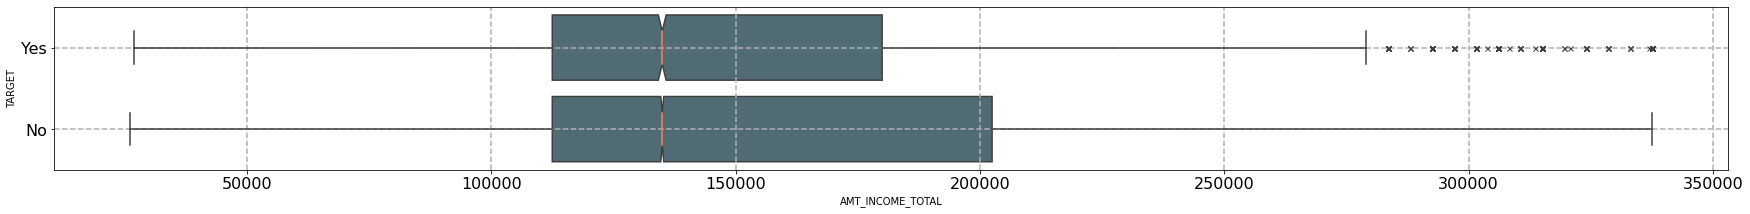

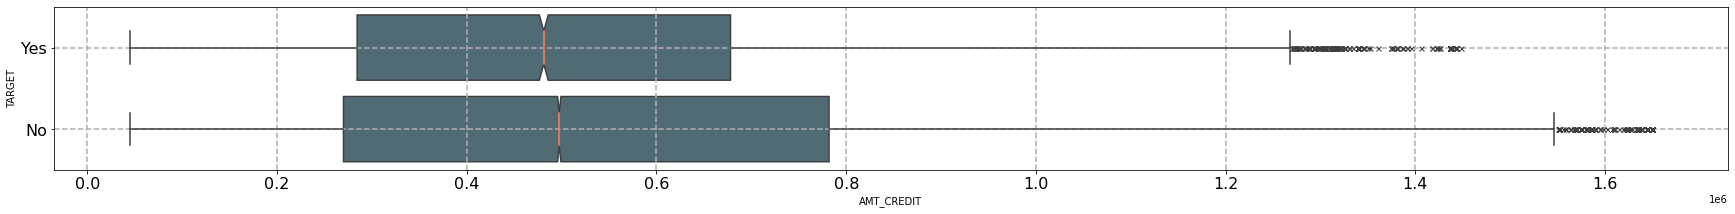

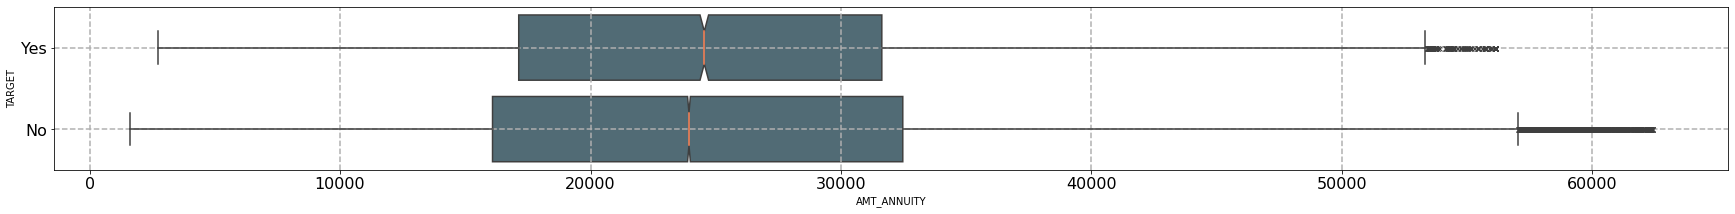

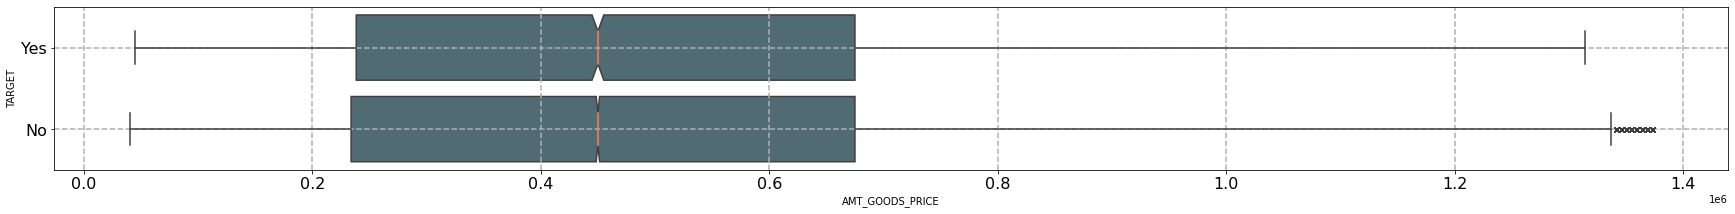

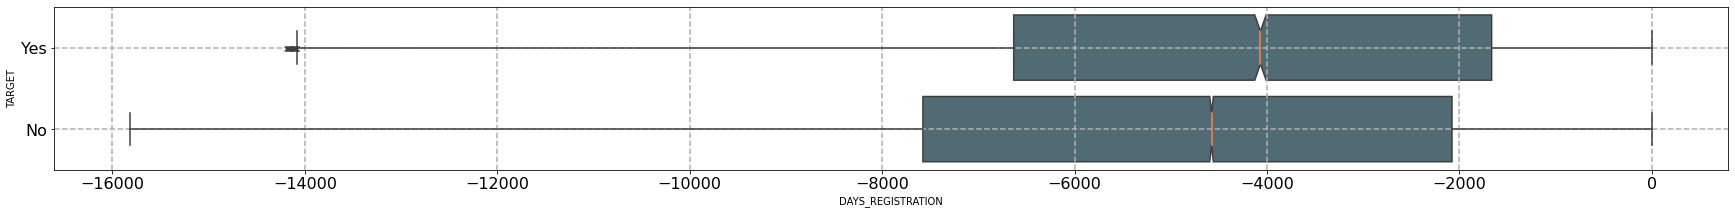

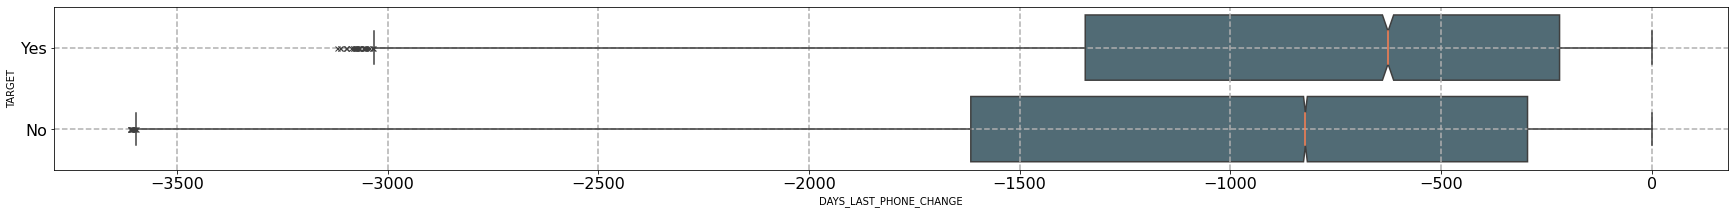

In [20]:
boxplot_by_targe(df_num_target_labeled_no_outliers.reset_index(drop=True), cols_selected, False)

Removing outliers

In [52]:
df_num = df_num.iloc[df_num_normal_no_outliers.index, :]
df = df.iloc[df_num_normal_no_outliers.index, :]

So as to avoid data drift, we need that the max and min values of each feature to be in the training set

In [53]:
X_max_min_values = []
for col in range_values.index:
    max_index, min_index = df_num[col].argmax(), df_num[col].argmin()
    X_max_min_values.append(max_index)
    X_max_min_values.append(min_index)

max_min_values = df.iloc[list(set(X_max_min_values))]
max_min_values.drop(columns=['SK_ID_CURR'], inplace=True)
df_without_min_max = df.drop(max_min_values.index)

We mix the dummified and categorical columns. The train set must have as unique values by column as the real dataset.

In [54]:
stratify_columns = list(categorical_columns) + list(nunique[nunique <= 3].index)
stratify_columns.pop(stratify_columns.index('TARGET'))

'TARGET'

We split data stritifying by the TARGET

In [61]:
X, y = df_without_min_max.drop(columns=['SK_ID_CURR','TARGET'], axis=1), df_without_min_max['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40, stratify=df_without_min_max['TARGET'])
X_train, y_train = pd.concat([X_train, max_min_values.drop(columns=['TARGET'])], axis=0), pd.concat([y_train, max_min_values['TARGET']], axis=0)

A look is taken to see if the categorical and dummified variables are balanced in its set.   
It is important that every category that appears in the test set, also appears in the training set. So if we obtain a 100% (1.0) in the first print, it will mean that in the train set we have all the categories.

In [62]:
print(np.array(X_train[stratify_columns].nunique()/df[stratify_columns].nunique()))
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0    0.921701
1    0.078299
Name: TARGET, dtype: float64
0    0.921697
1    0.078303
Name: TARGET, dtype: float64


#### Simple model for reference
---

The model and the scaler are instanciated. Just numeric features are used because when use graphs this are going to be the relations.   
The main goal of this is to have a simple reference of what can be done with the data hole data. Then we will perfome different strategies to remove fetures and see how the model behaves.

In [63]:
_some_params = {'n_estimators': [100], 'max_depth': [20] }
rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
scaler = StandardScaler()
X_train_num, X_test_num = X_train.select_dtypes(include=['float64', 'int64']), X_test.select_dtypes(include=['float64', 'int64'])

X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

In [64]:
cross_values = GridSearchCV(rf, param_grid=_some_params, cv=5, scoring='f1')
cross_values.fit(X_train_num_scaled, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_depth': [20], 'n_estimators': [100]},
             scoring='f1')

🛑🛑   **¡¡¡ EMPEORAN LOS RESULTADOS !!!** 🛑🛑

In [65]:
def get_scores(X_test_num_scaled, cross_values):
    y_pred = cross_values.predict(X_test_num_scaled)
    return pd.DataFrame({'auc': [roc_auc_score(y_test, y_pred)], 'f1': [f1_score(y_test, y_pred)], 'recall': [recall_score(y_test, y_pred)], 'precision': [precision_score(y_test, y_pred)]})

print(cross_values.cv_results_['mean_test_score'][0], cross_values.cv_results_['std_test_score'][0])
get_scores(X_test_num_scaled, cross_values)

0.23002939271356668 0.009590199803149301


,auc,f1,recall,precision
0,0.585844,0.241662,0.22713,0.258179


F1 score is used as principal metric, but others are also taking into account.

In [80]:
def get_scores(X_test_num_scaled, cross_values):
    y_pred = cross_values.predict(X_test_num_scaled)
    return pd.DataFrame({'auc': [roc_auc_score(y_test, y_pred)], 'f1': [f1_score(y_test, y_pred)], 'recall': [recall_score(y_test, y_pred)], 'precision': [precision_score(y_test, y_pred)]})

print(cross_values.cv_results_['mean_test_score'][0], cross_values.cv_results_['std_test_score'][0])
get_scores(X_test_num_scaled, cross_values)

0.21432099411189776 0.006763720475889411


,auc,f1,recall,precision
0,0.577757,0.230401,0.202312,0.267547


#### Correlation 
---

We create pearson and spearman correlation matrix

In [66]:
df_x_num = pd.concat([X_train.select_dtypes(include=['float64', 'int64']), y_train], axis=1)
df_x = pd.concat([X_train, y_train], axis=1)

df_corr_pearson = df_x_num.corr(method='pearson')
df_corr_spearman = df_x.corr(method='spearman')

We take a look at the correlation between the features and the target variable.
* No feature is highly correlated with the target variable.

In [67]:
display(df_corr_pearson['TARGET'].sort_values(ascending=False), '----------', df_corr_spearman['TARGET'].sort_values(ascending=False))

TARGET                         1.000000
DAYS_BIRTH                     0.083378
DAYS_LAST_PHONE_CHANGE         0.059918
DAYS_ID_PUBLISH                0.053043
REGION_RATING_CLIENT_W_CITY    0.052439
REGION_RATING_CLIENT           0.050411
REG_CITY_NOT_WORK_CITY         0.050274
FLAG_EMP_PHONE                 0.049793
REG_CITY_NOT_LIVE_CITY         0.045437
DAYS_REGISTRATION              0.045384
FLAG_DOCUMENT_3                0.040592
LIVE_CITY_NOT_WORK_CITY        0.031109
FLAG_WORK_PHONE                0.029533
DEF_30_CNT_SOCIAL_CIRCLE       0.029017
DEF_60_CNT_SOCIAL_CIRCLE       0.027826
AMT_REQ_CREDIT_BUREAU_YEAR     0.022663
CNT_CHILDREN                   0.019564
CNT_FAM_MEMBERS                0.012465
REG_REGION_NOT_WORK_REGION     0.010283
OBS_30_CNT_SOCIAL_CIRCLE       0.008998
OBS_60_CNT_SOCIAL_CIRCLE       0.008929
REG_REGION_NOT_LIVE_REGION     0.006458
LIVE_REGION_NOT_WORK_REGION    0.005872
AMT_REQ_CREDIT_BUREAU_DAY      0.005275
FLAG_DOCUMENT_21               0.005148


'----------'

TARGET                         1.000000
DAYS_BIRTH                     0.083394
DAYS_LAST_PHONE_CHANGE         0.056235
DAYS_ID_PUBLISH                0.053983
REGION_RATING_CLIENT_W_CITY    0.052507
REGION_RATING_CLIENT           0.050450
REG_CITY_NOT_WORK_CITY         0.050274
FLAG_EMP_PHONE                 0.049793
REG_CITY_NOT_LIVE_CITY         0.045437
DAYS_REGISTRATION              0.043247
FLAG_DOCUMENT_3                0.040592
LIVE_CITY_NOT_WORK_CITY        0.031109
DEF_30_CNT_SOCIAL_CIRCLE       0.030009
FLAG_WORK_PHONE                0.029533
DEF_60_CNT_SOCIAL_CIRCLE       0.027633
AMT_REQ_CREDIT_BUREAU_YEAR     0.021388
CNT_CHILDREN                   0.020691
DAYS_EMPLOYED                  0.020557
CNT_FAM_MEMBERS                0.010582
REG_REGION_NOT_WORK_REGION     0.010283
OBS_60_CNT_SOCIAL_CIRCLE       0.009627
OBS_30_CNT_SOCIAL_CIRCLE       0.009561
AMT_REQ_CREDIT_BUREAU_DAY      0.007621
REG_REGION_NOT_LIVE_REGION     0.006458
AMT_ANNUITY                    0.006355


Pairs of highly correlated features (are checked).   
Multiple ifs are done to avoid checking the same pair twice.

In [68]:
def correlated_features(df, threshold):
    list_correlations, detected_features = [], []
    for x in df.columns:
        corr_list = list(df[x][((df[x] > threshold) | (df[x] < -threshold)) & (df[x] != 1)].index)
        if len(corr_list) > 0: 
            detected_features.append(x)
            for y in corr_list: 
                if (y, x) not in list_correlations: list_correlations.append((x, y))
    return list_correlations, detected_features
    
pearson_correlated_features, pearson_detected_features = correlated_features(df_corr_pearson, 0.7)
spearman_correlated_features, spearman_detected_features = correlated_features(df_corr_spearman, 0.7)

As it can be seen, there are some features that are highly correlated with each other. This is a problem because it can lead to overfitting.  
The correlation obtained by pearson and spearman are very similar.

In [69]:
display(pearson_correlated_features)
display(spearman_correlated_features)

[('CNT_CHILDREN', 'CNT_FAM_MEMBERS'),
 ('AMT_CREDIT', 'AMT_ANNUITY'),
 ('AMT_CREDIT', 'AMT_GOODS_PRICE'),
 ('AMT_ANNUITY', 'AMT_GOODS_PRICE'),
 ('DAYS_EMPLOYED', 'FLAG_EMP_PHONE'),
 ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'),
 ('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION'),
 ('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')]

[('CNT_CHILDREN', 'CNT_FAM_MEMBERS'),
 ('AMT_CREDIT', 'AMT_ANNUITY'),
 ('AMT_CREDIT', 'AMT_GOODS_PRICE'),
 ('AMT_ANNUITY', 'AMT_GOODS_PRICE'),
 ('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY'),
 ('REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION'),
 ('REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY'),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE'),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE')]

So as to remove the correlated features, it is checked, by each pair, which of them has more correlation with the target variable.   
Other strategy is to check which of them has more correlation with the other features, however in this case one feaute just has correlation with 1 or 2 features.

In [70]:
less_correlated = abs(df_corr_pearson['TARGET'][pearson_detected_features]).sort_values(ascending=True)
delete_features = [x[1] if less_correlated[less_correlated.index == x[0]].values[0] > less_correlated[less_correlated.index == x[1]].values[0] is not None else x[0] for x in spearman_correlated_features]

Selected columns are removed

In [71]:
columns_iloc = [k for k, v in enumerate(X_train.select_dtypes(include=['float64', 'int64']).columns) if v not in delete_features]
X_train_num_scaled_no_correlated, X_test_num_scaled_no_correlated = X_train_num_scaled[:, columns_iloc], X_test_num_scaled[:, columns_iloc]

The model is trained on the data without correlated features.

In [72]:
cross_values_no_correlated = GridSearchCV(rf, param_grid=_some_params, cv=5, scoring='f1')
cross_values_no_correlated.fit(X_train_num_scaled_no_correlated, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_depth': [20], 'n_estimators': [100]},
             scoring='f1')

🛑🛑   **¡¡¡ EMPEORAN LOS RESULTADOS !!!** 🛑🛑

In [73]:
print(cross_values_no_correlated.cv_results_['mean_test_score'][0], cross_values_no_correlated.cv_results_['std_test_score'][0])
display(get_scores(X_test_num_scaled, cross_values))
display(get_scores(X_test_num_scaled_no_correlated, cross_values_no_correlated))

0.22434846462681213 0.008867254124758034


,auc,f1,recall,precision
0,0.585844,0.241662,0.22713,0.258179


,auc,f1,recall,precision
0,0.582813,0.237183,0.218866,0.258847


It looks like the results have improve with a reduction of 15% of the features

In [81]:
print(cross_values_no_correlated.cv_results_['mean_test_score'][0], cross_values_no_correlated.cv_results_['std_test_score'][0])
display(get_scores(X_test_num_scaled, cross_values))
display(get_scores(X_test_num_scaled_no_correlated, cross_values_no_correlated))

0.21236366138026314 0.004156682439537593


,auc,f1,recall,precision
0,0.577757,0.230401,0.202312,0.267547


,auc,f1,recall,precision
0,0.580743,0.234405,0.211771,0.262455


### Feature selection
----

A randomforest model is trained and the features with more than 1% of importance are selected

In [74]:
rf.fit(X_train_num_scaled, y_train)
feature_importances_index = [k for k, v in enumerate(rf.feature_importances_) if v > 0.01]

The model is trained again with the selected features.

In [75]:
cross_values_feature_importances = GridSearchCV(rf, param_grid=_some_params, cv=5, scoring='f1')
cross_values_feature_importances.fit(X_train_num_scaled[:, feature_importances_index], y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_depth': [20], 'n_estimators': [100]},
             scoring='f1')

As it can be seen no improvement is obtained.

In [76]:
print(cross_values_feature_importances.cv_results_['mean_test_score'][0], cross_values_feature_importances.cv_results_['std_test_score'][0])
display(get_scores(X_test_num_scaled, cross_values))
display(get_scores(X_test_num_scaled_no_correlated, cross_values_no_correlated))
display(get_scores(X_test_num_scaled[:, feature_importances_index], cross_values_feature_importances))

0.22325378399097578 0.008283306950965394


,auc,f1,recall,precision
0,0.585844,0.241662,0.22713,0.258179


,auc,f1,recall,precision
0,0.582813,0.237183,0.218866,0.258847


,auc,f1,recall,precision
0,0.578556,0.231249,0.206042,0.263484


### PCA
---

PCA es also used for the dimensionality reduction

In [77]:
pca = PCA(n_components=X_test_num_scaled_no_correlated.shape[1])
X_train_num_scaled_no_correlated_pca = pca.fit_transform(X_train_num_scaled_no_correlated)

PCA plotting function

In [ ]:
def get_n_components(pca_ratio, threshold):

    fig = plt.figure(figsize=(30, 8))
    colors = ['#264653' if x < threshold else '#E76F51' for x in pca_ratio]

    plt.scatter(range(len(pca_ratio)), pca_ratio, color = colors, s = 100);
    plt.xlabel('Nº features', fontdict={'size': 20, 'color': 'black', 'weight': 'bold'})
    plt.ylabel('Accumulated variance', fontdict={'size': 20, 'color': 'black', 'weight': 'bold'})
    plt.title(f'Accumulated variance', fontdict={'size': 20, 'color': 'black', 'weight': 'bold'})
    
    plt.grid(linestyle='--',linewidth=1.5), plt.xticks(fontsize=16), plt.yticks(fontsize=16);

Taking a look at the explained variance ratio of the principal components:

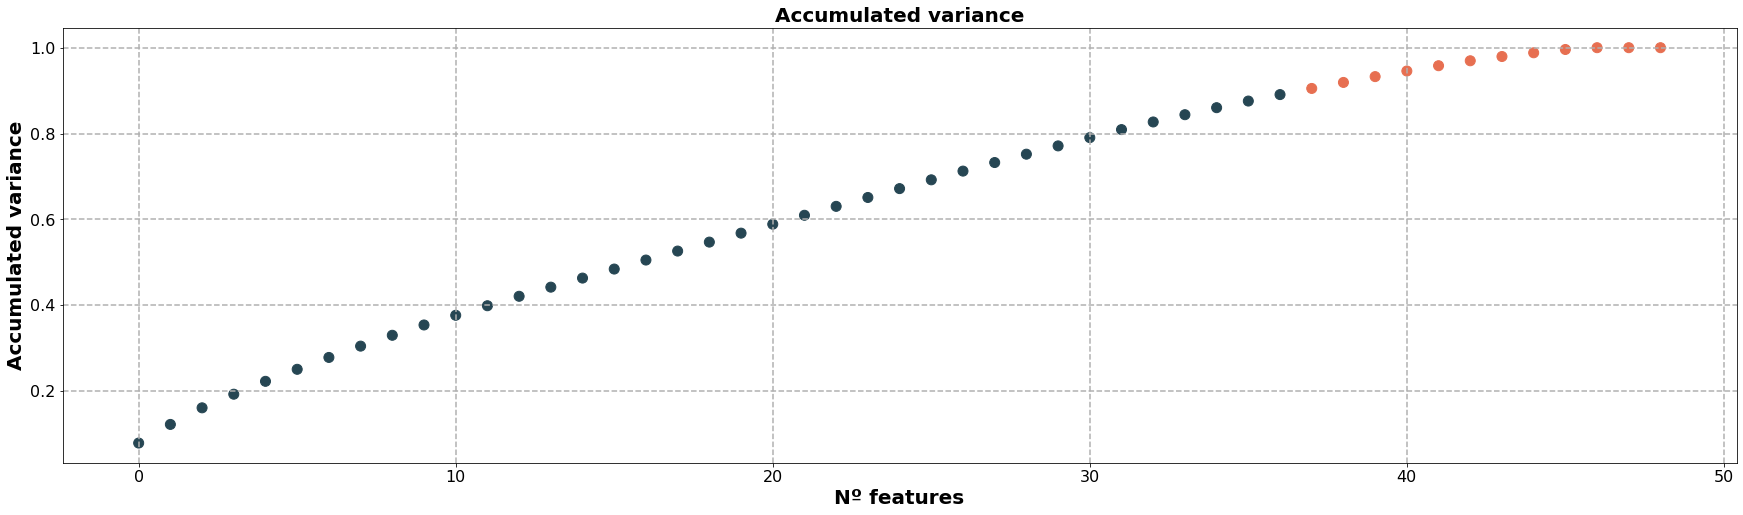

In [78]:
pca_ratio = pca.explained_variance_ratio_.cumsum()
get_n_components(pca_ratio, 0.9)

A threshold of 0.9 is reached at 11 components.

In [79]:
pca = PCA(n_components=pca_ratio[pca_ratio < 0.9].shape[0])
X_train_num_scaled_no_correlated_pca = pca.fit_transform(X_train_num_scaled_no_correlated)

Once again we train and compare with the previus results

In [80]:
cross_values_pca = GridSearchCV(rf, param_grid=_some_params, cv=5, scoring='f1')
cross_values_pca.fit(X_train_num_scaled_no_correlated_pca, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=42),
             param_grid={'max_depth': [20], 'n_estimators': [100]},
             scoring='f1')

In [81]:
X_test_num_scaled_no_correlated_pca = pca.transform(X_test_num_scaled_no_correlated)[:, :pca_ratio[pca_ratio < 0.9].shape[0]]

print(cross_values_pca.cv_results_['mean_test_score'][0], cross_values_pca.cv_results_['std_test_score'][0])
display(get_scores(X_test_num_scaled_no_correlated, cross_values_no_correlated))
display(get_scores(X_test_num_scaled_no_correlated_pca, cross_values_pca))

0.1654046885647321 0.010252525193260316


,auc,f1,recall,precision
0,0.582813,0.237183,0.218866,0.258847


,auc,f1,recall,precision
0,0.551151,0.178578,0.129952,0.285357


### Save model
---

1. Get the non correlated numeric values
2. Train the scaler
3. Concat the categorical features
4. Save all

* Step: 1

In [170]:
X_train_num, X_test_num, X_train_cat, X_test_cat = X_train.select_dtypes(include=['float64', 'int64']), X_test.select_dtypes(include=['float64', 'int64']), 
                                                   X_train.select_dtypes(include=['object']), X_test.select_dtypes(include=['object'])


* Step: 2, 3

In [186]:
scaler_save = StandardScaler()
X_train_save, X_test_save = X_train_num.iloc[:, columns_iloc], X_test_num.iloc[:, columns_iloc]
scaler_save.fit(X_train_save)

X_train_save, X_test_save = pd.concat([X_train_save, X_train_cat], axis=1), pd.concat([X_test_save, X_test_cat], axis=1)

* Step 4

In [194]:
def save_pickle_file(file_name, file):
    with open(path + file_name, 'wb') as f: pickle.dump(file, f)

save_pickle_file('scaler_save.pkl', scaler_save), save_pickle_file('X_train_save.pkl', X_train_save)
save_pickle_file('X_test_save.pkl', X_test_save), save_pickle_file('y_train.pkl', y_train), save_pickle_file('y_test.pkl', y_test)

(None, None, None)

---